In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import layers, models, initializers, optimizers
import numpy as np
import matplotlib.pyplot as plt

n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = tf.ones((num_inputs, 1)) * 0.01, 0.05

features = tf.random.normal(shape=(n_train + n_test, num_inputs))
labels = tf.keras.backend.dot(features, true_w) + true_b
labels += tf.random.normal(mean=0.01, shape=labels.shape)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]


In [2]:
def init_params():
    w = tf.Variable(tf.random.normal(mean=1, shape=(num_inputs, 1)))
    b = tf.Variable(tf.zeros(shape=(1,)))
    return [w, b]
def l2_penalty(w):
    return tf.reduce_sum((w**2)) / 2
def linreg(X, w, b):
    return tf.matmul(X, w) + b
def squared_loss(y_hat, y):
    return (y_hat - tf.reshape(y, y_hat.shape)) ** 2 /2
def sgd(params, lr, batch_size, grads):
    """Mini-batch stochastic gradient descent."""
    for i, param in enumerate(params):
        param.assign_sub(lr * grads[i] / batch_size)
from IPython import display
def use_svg_display():
    """Use svg format to display plot in jupyter"""
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    """Set matplotlib figure size."""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)
    plt.show()

In [3]:
batch_size, num_epochs, lr = 1, 100, 0.003
loss = squared_loss
net = linreg
optimizer = tf.keras.optimizers.SGD()
train_iter = tf.data.Dataset.from_tensor_slices(
    (train_features, train_labels)).batch(batch_size).shuffle(batch_size)

def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape(persistent=True) as tape:
                # 添加了L2范数惩罚项
                l = loss(net(X, w, b), y) + lambd * l2_penalty(w)
            grads = tape.gradient(l, [w, b])
            sgd([w, b], lr, batch_size, grads)
        train_ls.append(tf.reduce_mean(loss(net(train_features, w, b),
                             train_labels)).numpy())
        test_ls.append(tf.reduce_mean(loss(net(test_features, w, b),
                            test_labels)).numpy())
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', tf.norm(w).numpy())


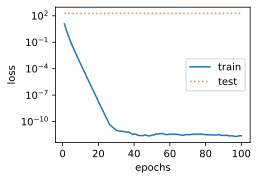

L2 norm of w: 18.519138


In [4]:
fit_and_plot(lambd=0)

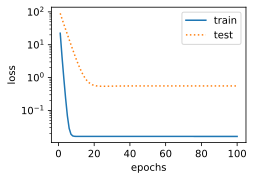

L2 norm of w: 0.24311268


In [5]:
fit_and_plot(lambd=3)

In [6]:
def fit_and_plot_tf2(wd, lr=1e-3):
    net = models.Sequential()
    net.add(layers.Dense(1))
    net.build(input_shape=(1, 200))
    w, b = net.trainable_variables
    optimizer = optimizers.SGD(learning_rate=lr)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                l = loss(net(X), y) + wd * l2_penalty(w)
            grads = tape.gradient(l, net.trainable_variables)
            optimizer.apply_gradients(zip(grads, net.trainable_variables))
        train_ls.append(tf.reduce_mean(loss(net(train_features),
                             train_labels)).numpy())
        test_ls.append(tf.reduce_mean(loss(net(test_features),
                            test_labels)).numpy())
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', tf.norm(w).numpy())


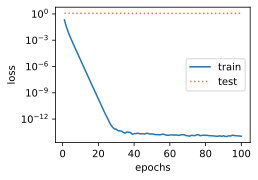

L2 norm of w: 1.3202068


In [7]:
fit_and_plot_tf2(0, lr)

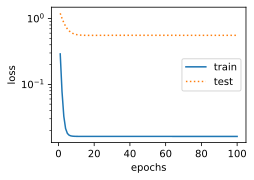

L2 norm of w: 0.24312723


In [8]:
fit_and_plot_tf2(3, lr)